# W207 Final Project - Facial Keypoint Recognition Baseline
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

In [1]:
%matplotlib inline


import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time
import os.path
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.3.0


In [5]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


### Load Data 

In [3]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


# Need to clean up a few NA's in our set


In [4]:
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [25]:
X = np.array([two_dim(train.Image[i]) for i in range(len(train))])
# X = np.array([make_array(train.Image[i]) for i in range(len(train))])
X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

#Need to make X_test and Y_test (will we have a Y_test? I think that may be handled in Kaggle)

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
# numTestExamples = test_data.shape[0]
print(f'Train examples {numTrainExamples}')
print(f'Train features {numFeatures}')
print(f'mini_Train examples {numMiniExamples}')
print(f'Dev examples {numDevExamples}')
# print(f'Test examples {numTestExamples}')

Train examples 5000
Train features 9216
mini_Train examples 1000
Dev examples 2049


In [39]:
#EDA see how many na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

In [6]:
#Drop all NAs to have a clean fully labeled dataset
train_noNA = train.dropna(axis=0, how='any', inplace = False)
train_noNA = train_noNA.reset_index(drop=True)
print(len(train))
print(len(train_noNA))

7049
2140


## Analysis without NA's
We lose 70% of the dataset when removing NAs

In [14]:
#transform dataset into train and dev
X_noNA = np.array([make_array(train_noNA.Image[i]) for i in range(len(train_noNA))])
X_noNA = X_noNA / 255.0
Y_noNA = np.array([train_noNA.drop('Image', axis = 1).iloc[i] for i in range(len(train_noNA))])
noNA_train_data, noNA_train_labels = X_noNA[:1200], Y_noNA[:1200]
noNA_dev_data, noNA_dev_labels = X_noNA[1200:], Y_noNA[1200:]

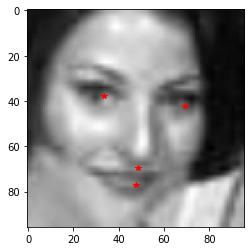

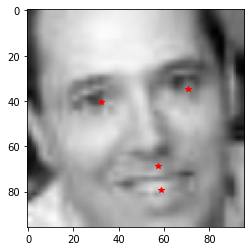

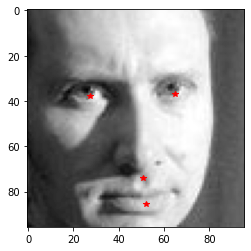

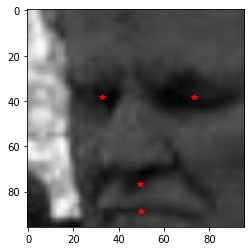

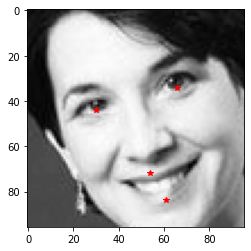

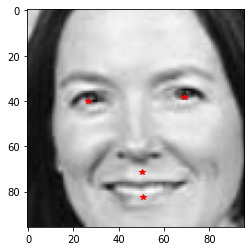

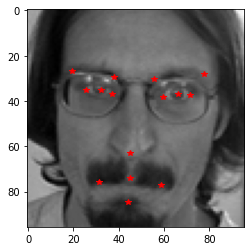

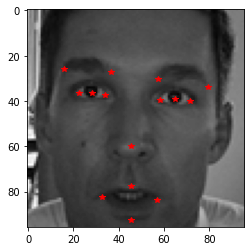

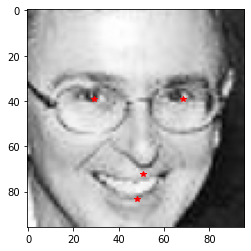

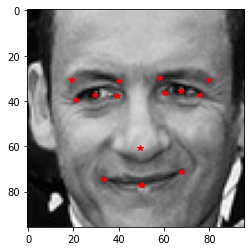

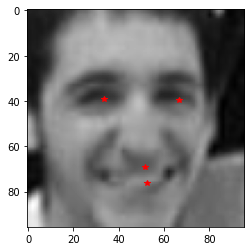

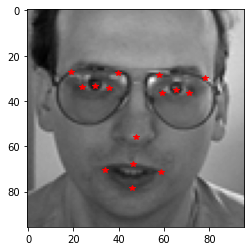

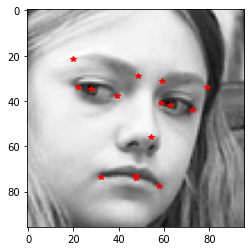

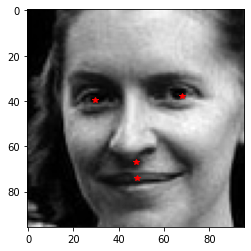

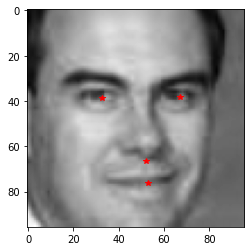

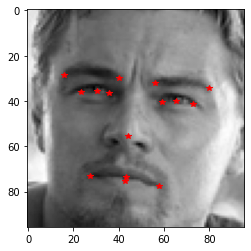

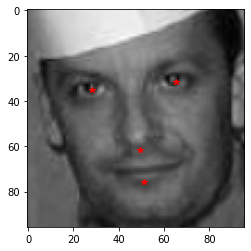

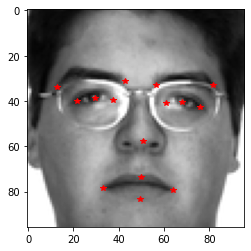

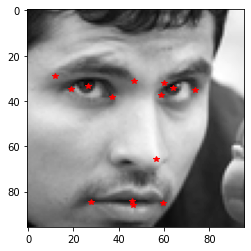

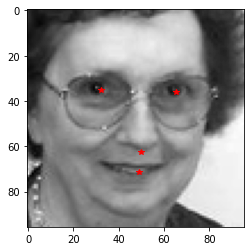

In [41]:
#explore some of the images in the training data
for i in range(20):
    plt.imshow(train_data[i].reshape(96,96),cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(train_labels[i][loc], train_labels[i][loc+1], '*r')
    plt.show() 
    

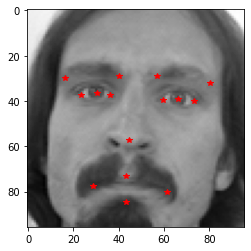

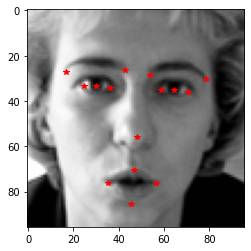

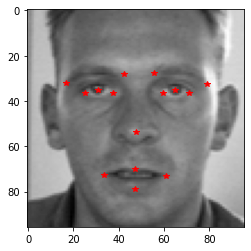

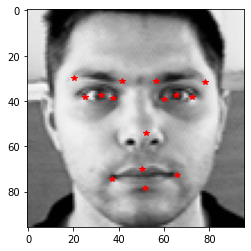

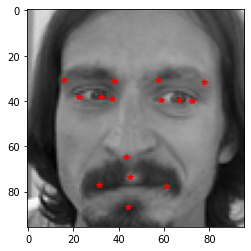

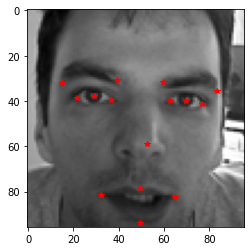

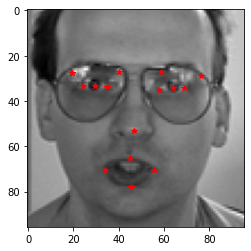

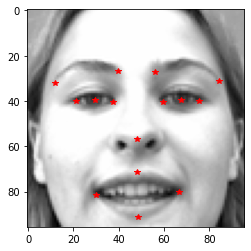

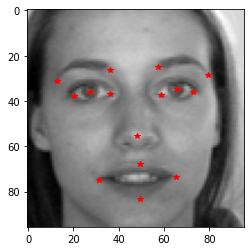

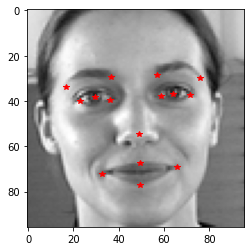

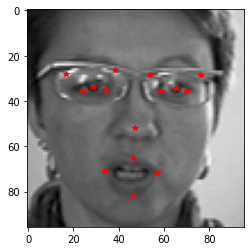

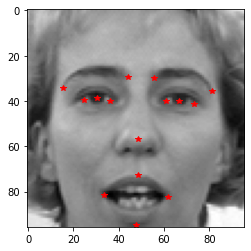

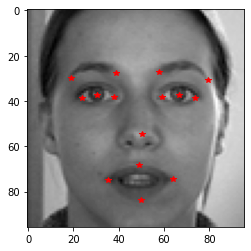

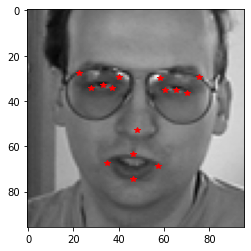

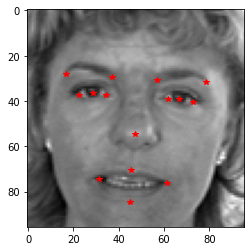

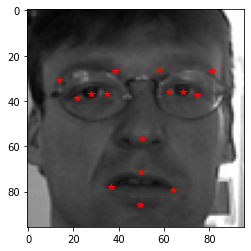

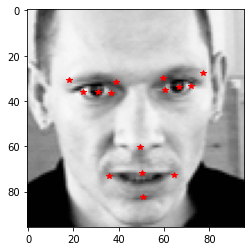

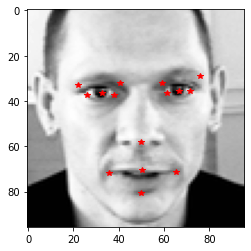

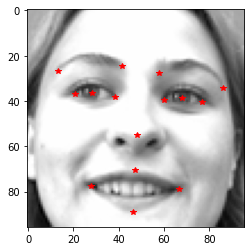

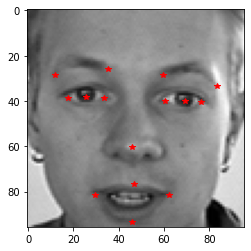

In [42]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
#explore some of the images in the training data
for i in range(20):
    plt.imshow(noNA_train_data[i].reshape(96,96),cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(noNA_train_labels[i][loc], noNA_train_labels[i][loc+1], '*r')
    plt.show() 
    

In [44]:
#List all features
for col in train.columns:
    if col != 'Image':
        print(col)

left_eye_center_x
left_eye_center_y
right_eye_center_x
right_eye_center_y
left_eye_inner_corner_x
left_eye_inner_corner_y
left_eye_outer_corner_x
left_eye_outer_corner_y
right_eye_inner_corner_x
right_eye_inner_corner_y
right_eye_outer_corner_x
right_eye_outer_corner_y
left_eyebrow_inner_end_x
left_eyebrow_inner_end_y
left_eyebrow_outer_end_x
left_eyebrow_outer_end_y
right_eyebrow_inner_end_x
right_eyebrow_inner_end_y
right_eyebrow_outer_end_x
right_eyebrow_outer_end_y
nose_tip_x
nose_tip_y
mouth_left_corner_x
mouth_left_corner_y
mouth_right_corner_x
mouth_right_corner_y
mouth_center_top_lip_x
mouth_center_top_lip_y
mouth_center_bottom_lip_x
mouth_center_bottom_lip_y


array([[<AxesSubplot:title={'center':'left_eye_center_x'}>,
        <AxesSubplot:title={'center':'left_eye_center_y'}>,
        <AxesSubplot:title={'center':'right_eye_center_x'}>,
        <AxesSubplot:title={'center':'right_eye_center_y'}>,
        <AxesSubplot:title={'center':'left_eye_inner_corner_x'}>],
       [<AxesSubplot:title={'center':'left_eye_inner_corner_y'}>,
        <AxesSubplot:title={'center':'left_eye_outer_corner_x'}>,
        <AxesSubplot:title={'center':'left_eye_outer_corner_y'}>,
        <AxesSubplot:title={'center':'right_eye_inner_corner_x'}>,
        <AxesSubplot:title={'center':'right_eye_inner_corner_y'}>],
       [<AxesSubplot:title={'center':'right_eye_outer_corner_x'}>,
        <AxesSubplot:title={'center':'right_eye_outer_corner_y'}>,
        <AxesSubplot:title={'center':'left_eyebrow_inner_end_x'}>,
        <AxesSubplot:title={'center':'left_eyebrow_inner_end_y'}>,
        <AxesSubplot:title={'center':'left_eyebrow_outer_end_x'}>],
       [<AxesSubplot:t

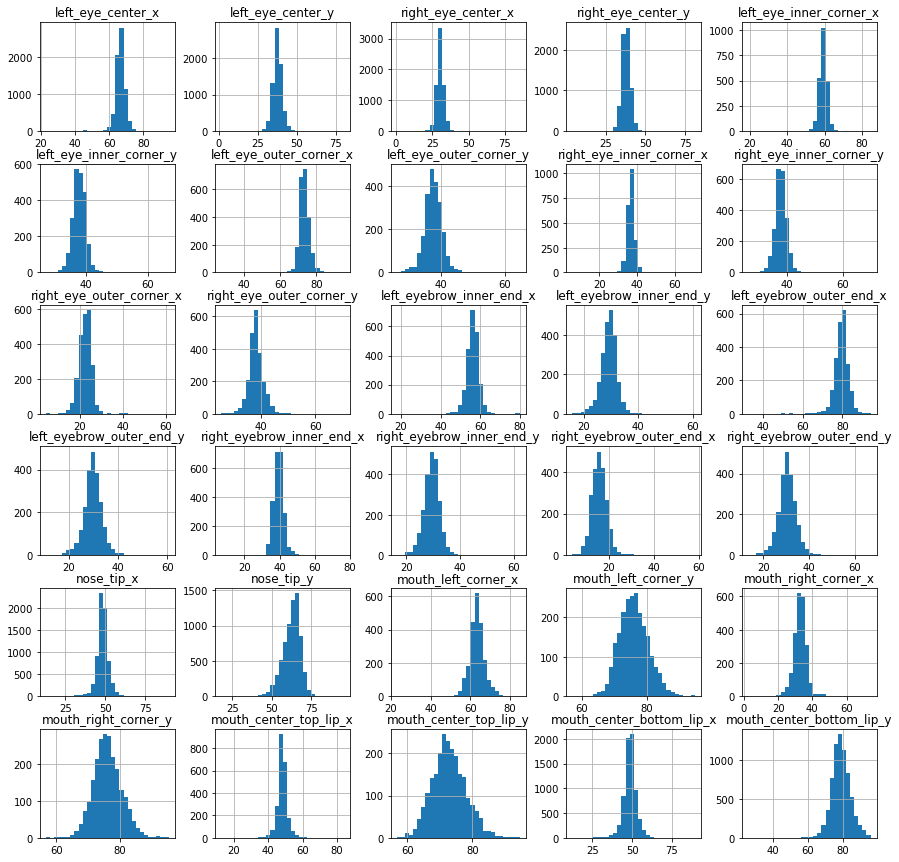

In [45]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))

In [47]:
#create df for noNA data to do the same analysis as above
tempdf = pd.DataFrame(noNA_train_labels)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>],
       [<AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>],
       [<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>],
       [<AxesSubplot:title={'center':'15'}>,
        <AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'18'}>,
        <AxesSubplot:title={'center':'19'}>],
       [<AxesSubplot:title={'center':'20'}>,
        <AxesSubplot:title={'center':'21'}>,
        <AxesSub

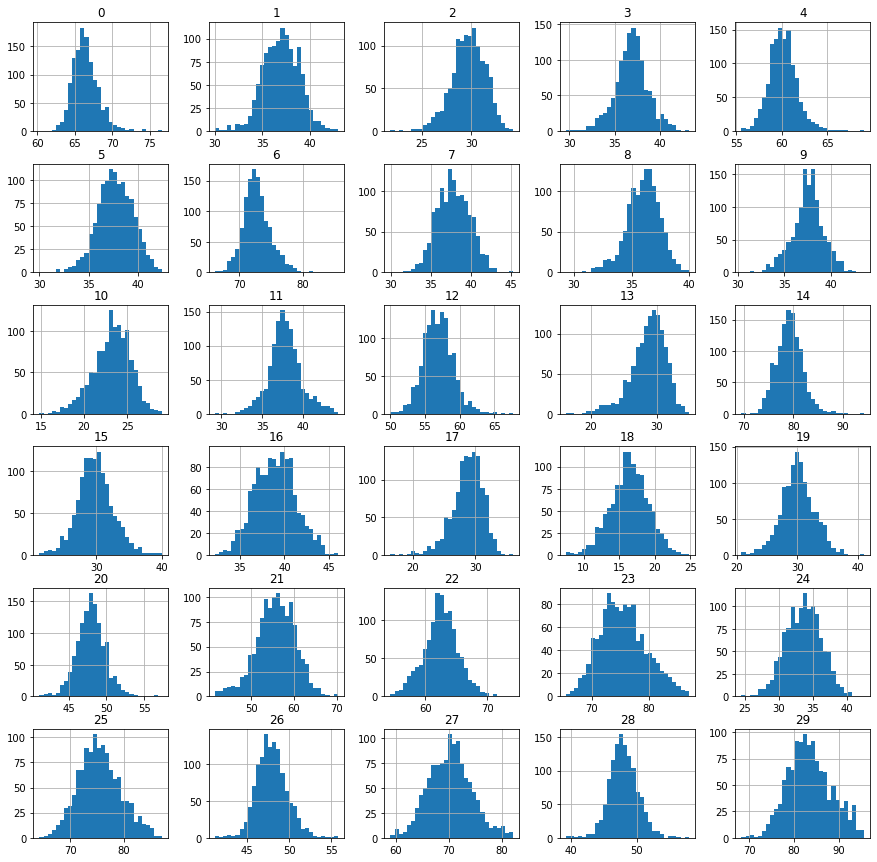

In [48]:
tempdf.hist(bins = 30, figsize=(15,15))

Use the next two cells if you want to explore the dev data to make sure it's clean as well

In [49]:
#tempdf = pd.DataFrame(noNA_dev_labels)

In [50]:
#tempdf.hist(bins = 30, figsize=(15,15))

In [52]:
#Confirm size of the datasets
print(noNA_train_data.shape)
print(noNA_train_labels.shape)
print(noNA_dev_data.shape)
print(noNA_dev_labels.shape)

(1200, 9216)
(1200, 30)
(940, 9216)
(940, 30)


### Exploratory Data Analysis (with NAs)

LEFT_EYE_CENTER_X

count    7039.000000
mean       66.359021
std         3.448233
min        22.763345
25%        65.082895
50%        66.497566
75%        68.024752
max        94.689280
Name: left_eye_center_x, dtype: float64

PLOT:


/Users/gregrosen/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/gregrosen/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


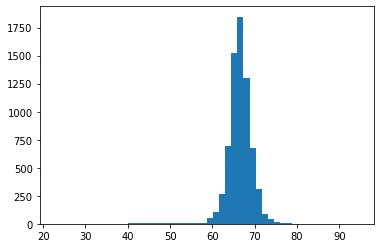


LEFT_EYE_CENTER_Y

count    7039.000000
mean       37.651234
std         3.152926
min         1.616512
25%        35.900451
50%        37.528055
75%        39.258449
max        80.502649
Name: left_eye_center_y, dtype: float64

PLOT:


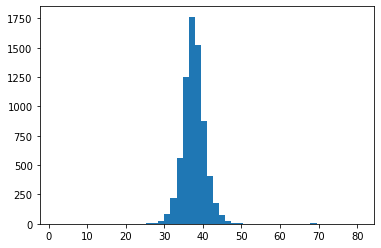


RIGHT_EYE_CENTER_X

count    7036.000000
mean       30.306102
std         3.083230
min         0.686592
25%        28.783339
50%        30.251378
75%        31.768334
max        85.039381
Name: right_eye_center_x, dtype: float64

PLOT:


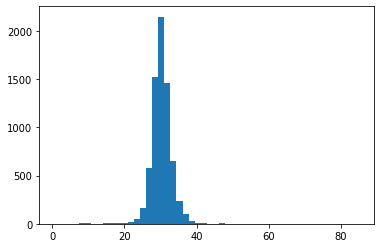


RIGHT_EYE_CENTER_Y

count    7036.000000
mean       37.976943
std         3.033621
min         4.091264
25%        36.327681
50%        37.813273
75%        39.566729
max        81.270911
Name: right_eye_center_y, dtype: float64

PLOT:


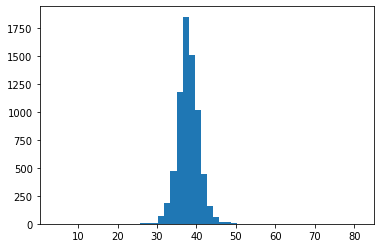


LEFT_EYE_INNER_CORNER_X

count    2271.000000
mean       59.159339
std         2.690354
min        19.064954
25%        58.039339
50%        59.304615
75%        60.519810
max        84.440991
Name: left_eye_inner_corner_x, dtype: float64

PLOT:


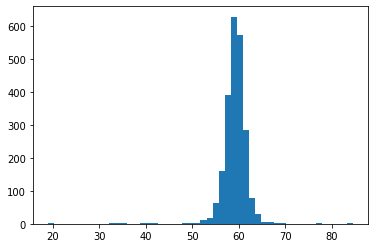


LEFT_EYE_INNER_CORNER_Y

count    2271.000000
mean       37.944752
std         2.307332
min        27.190098
25%        36.626283
50%        37.878040
75%        39.260348
max        66.562559
Name: left_eye_inner_corner_y, dtype: float64

PLOT:


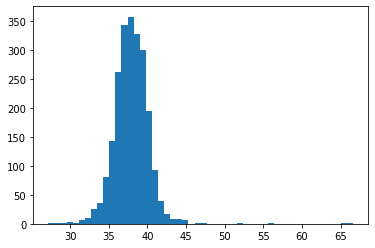


LEFT_EYE_OUTER_CORNER_X

count    2267.000000
mean       73.330478
std         3.405852
min        27.571879
25%        71.716503
50%        73.247824
75%        75.015645
max        95.258090
Name: left_eye_outer_corner_x, dtype: float64

PLOT:


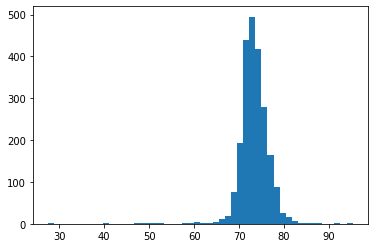


LEFT_EYE_OUTER_CORNER_Y

count    2267.000000
mean       37.707008
std         2.881438
min        26.250023
25%        36.085523
50%        37.639015
75%        39.373489
max        64.618230
Name: left_eye_outer_corner_y, dtype: float64

PLOT:


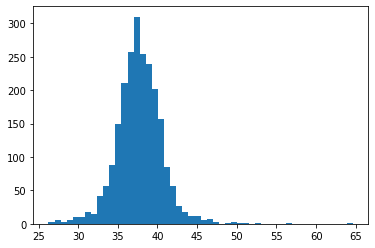


RIGHT_EYE_INNER_CORNER_X

count    2268.000000
mean       36.652607
std         2.350268
min         5.751046
25%        35.506126
50%        36.651562
75%        37.753571
max        70.714966
Name: right_eye_inner_corner_x, dtype: float64

PLOT:


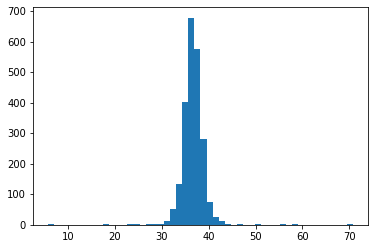


RIGHT_EYE_INNER_CORNER_Y

count    2268.000000
mean       37.989902
std         2.311907
min        26.250023
25%        36.766783
50%        37.944075
75%        39.192917
max        69.808803
Name: right_eye_inner_corner_y, dtype: float64

PLOT:


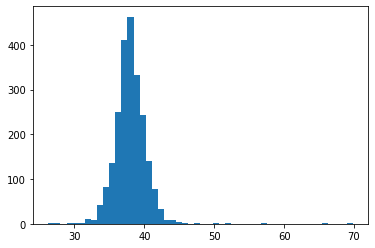


RIGHT_EYE_OUTER_CORNER_X

count    2268.000000
mean       22.384504
std         3.057122
min         3.980117
25%        20.585808
50%        22.535954
75%        24.237701
max        61.428580
Name: right_eye_outer_corner_x, dtype: float64

PLOT:


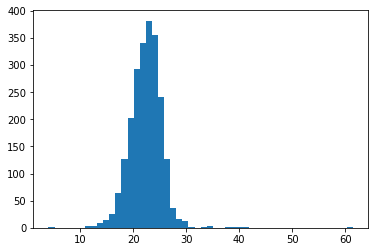


RIGHT_EYE_OUTER_CORNER_Y

count    2268.000000
mean       38.033495
std         2.910368
min        25.123828
25%        36.534382
50%        37.867071
75%        39.415051
max        70.746797
Name: right_eye_outer_corner_y, dtype: float64

PLOT:


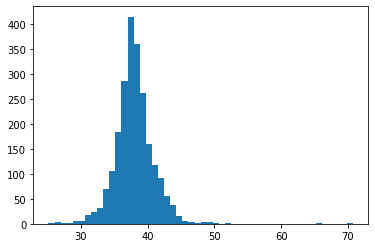


LEFT_EYEBROW_INNER_END_X

count    2270.000000
mean       56.068513
std         3.485485
min        17.888717
25%        54.515587
50%        56.244975
75%        57.946415
max        79.787831
Name: left_eyebrow_inner_end_x, dtype: float64

PLOT:


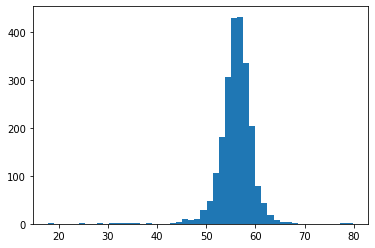


LEFT_EYEBROW_INNER_END_Y

count    2270.000000
mean       29.332678
std         3.078134
min        15.859361
25%        27.617244
50%        29.528872
75%        31.158830
max        60.875896
Name: left_eyebrow_inner_end_y, dtype: float64

PLOT:


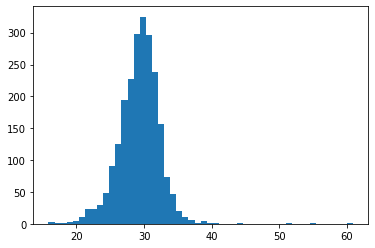


LEFT_EYEBROW_OUTER_END_X

count    2225.000000
mean       79.482826
std         3.986224
min        32.206432
25%        77.673916
50%        79.784229
75%        81.590720
max        94.269957
Name: left_eyebrow_outer_end_x, dtype: float64

PLOT:


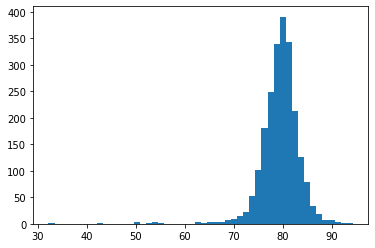


LEFT_EYEBROW_OUTER_END_Y

count    2225.000000
mean       29.734861
std         3.773744
min        10.522325
25%        27.667948
50%        29.773813
75%        31.835621
max        60.500298
Name: left_eyebrow_outer_end_y, dtype: float64

PLOT:


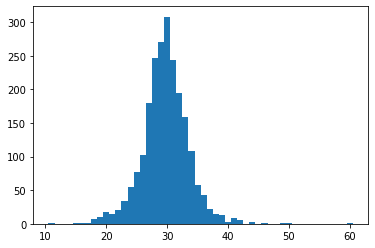


RIGHT_EYEBROW_INNER_END_X

count    2270.000000
mean       39.322137
std         3.209641
min         6.921014
25%        37.552286
50%        39.298848
75%        40.917160
max        76.582388
Name: right_eyebrow_inner_end_x, dtype: float64

PLOT:


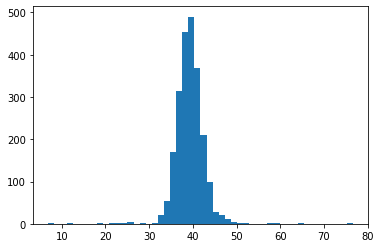


RIGHT_EYEBROW_INNER_END_Y

count    2270.000000
mean       29.502998
std         3.106869
min        16.476000
25%        27.790607
50%        29.569347
75%        31.251664
max        62.083177
Name: right_eyebrow_inner_end_y, dtype: float64

PLOT:


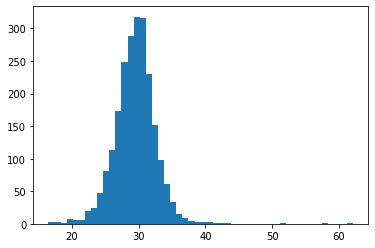


RIGHT_EYEBROW_OUTER_END_X

count    2236.000000
mean       15.871177
std         3.622533
min         3.826243
25%        13.562183
50%        15.785709
75%        17.999040
max        58.418216
Name: right_eyebrow_outer_end_x, dtype: float64

PLOT:


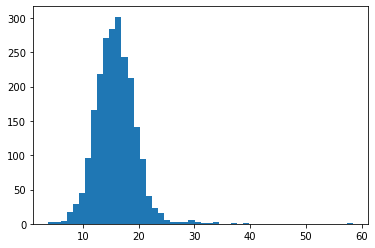


RIGHT_EYEBROW_OUTER_END_Y

count    2236.000000
mean       30.428166
std         3.865772
min        13.224453
25%        28.206046
50%        30.320160
75%        32.654768
max        66.751329
Name: right_eyebrow_outer_end_y, dtype: float64

PLOT:


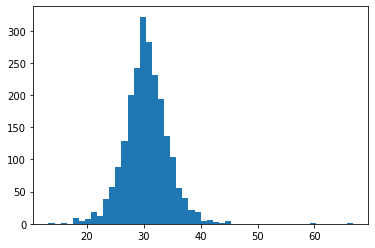


NOSE_TIP_X

count    7049.000000
mean       48.374186
std         4.280038
min        12.944699
25%        46.602370
50%        48.424713
75%        50.330437
max        89.438592
Name: nose_tip_x, dtype: float64

PLOT:


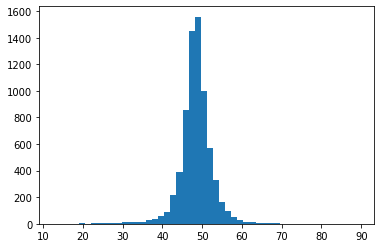


NOSE_TIP_Y

count    7049.000000
mean       62.715884
std         5.720567
min        17.932414
25%        59.292697
50%        63.451421
75%        66.492686
max        95.935644
Name: nose_tip_y, dtype: float64

PLOT:


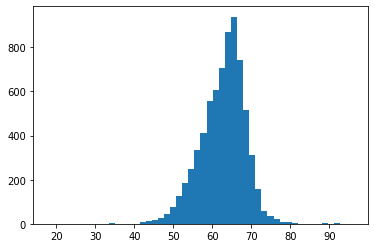


MOUTH_LEFT_CORNER_X

count    2269.000000
mean       63.285735
std         4.079063
min        22.923362
25%        61.257143
50%        63.178286
75%        65.376243
max        84.767123
Name: mouth_left_corner_x, dtype: float64

PLOT:


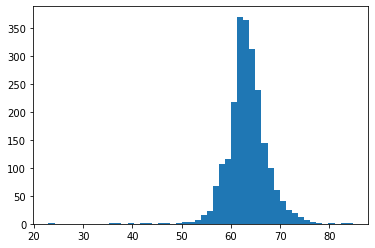


MOUTH_LEFT_CORNER_Y

count    2269.000000
mean       75.970714
std         4.579724
min        57.023258
25%        72.875707
50%        75.778689
75%        78.879123
max        94.673637
Name: mouth_left_corner_y, dtype: float64

PLOT:


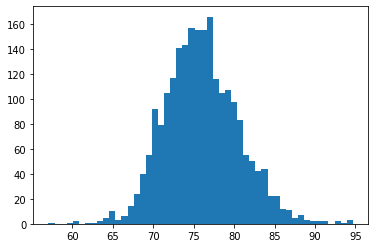


MOUTH_RIGHT_CORNER_X

count    2270.000000
mean       32.900404
std         3.964552
min         2.245766
25%        30.797646
50%        32.982305
75%        35.101302
max        74.017993
Name: mouth_right_corner_x, dtype: float64

PLOT:


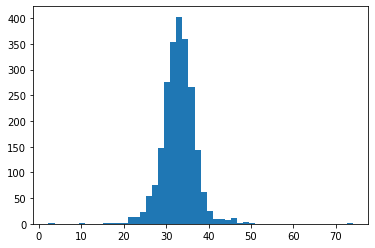


MOUTH_RIGHT_CORNER_Y

count    2270.000000
mean       76.179768
std         4.417814
min        56.690208
25%        73.256472
50%        76.000592
75%        78.956357
max        95.510678
Name: mouth_right_corner_y, dtype: float64

PLOT:


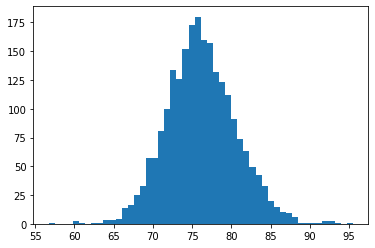


MOUTH_CENTER_TOP_LIP_X

count    2275.000000
mean       47.975412
std         3.323060
min        12.605173
25%        46.494571
50%        47.905490
75%        49.296488
max        83.989082
Name: mouth_center_top_lip_x, dtype: float64

PLOT:


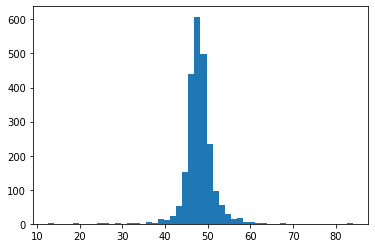


MOUTH_CENTER_TOP_LIP_Y

count    2275.000000
mean       72.919443
std         5.222500
min        56.719043
25%        69.396748
50%        72.605173
75%        76.221644
max        94.548359
Name: mouth_center_top_lip_y, dtype: float64

PLOT:


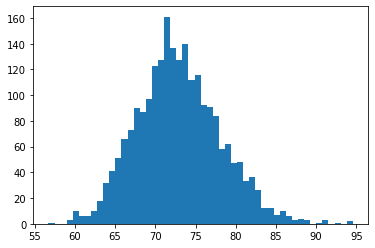


MOUTH_CENTER_BOTTOM_LIP_X

count    7016.000000
mean       48.569472
std         4.269961
min        12.536477
25%        46.573703
50%        48.594978
75%        50.677631
max        89.438592
Name: mouth_center_bottom_lip_x, dtype: float64

PLOT:


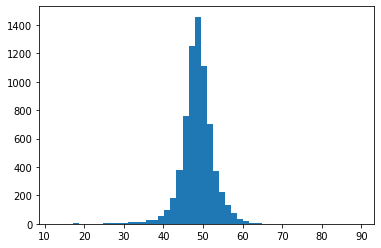


MOUTH_CENTER_BOTTOM_LIP_Y

count    7016.000000
mean       78.970146
std         5.407844
min        25.850503
25%        75.549715
50%        78.696326
75%        82.233993
max        95.808983
Name: mouth_center_bottom_lip_y, dtype: float64

PLOT:


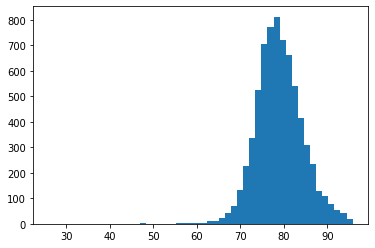

In [91]:
# before imputation
for col in train.drop(columns="Image"):
    print(col.upper())
    print()
    print(train[col].describe())
    print()
    print("PLOT:")
    plt.hist(col, data = train, bins = 50)
    plt.show()
    print()

LEFT_EYE_CENTER_X

count    7049.000000
mean       66.358588
std         3.447098
min        22.763345
25%        65.082643
50%        66.493907
75%        68.024628
max        94.689280
Name: left_eye_center_x, dtype: float64

PLOT:


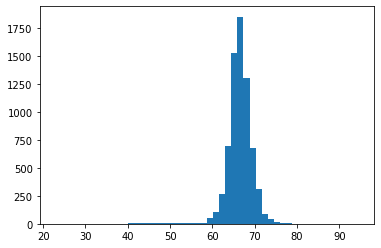


LEFT_EYE_CENTER_Y

count    7049.000000
mean       37.649140
std         3.152072
min         1.616512
25%        35.900605
50%        37.526919
75%        39.254400
max        80.502649
Name: left_eye_center_y, dtype: float64

PLOT:


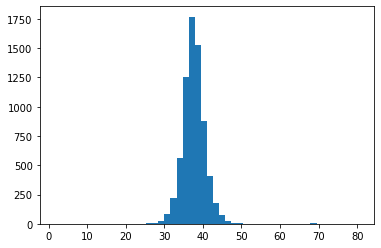


RIGHT_EYE_CENTER_X

count    7049.000000
mean       30.306631
std         3.083087
min         0.686592
25%        28.782316
50%        30.253135
75%        31.768407
max        85.039381
Name: right_eye_center_x, dtype: float64

PLOT:


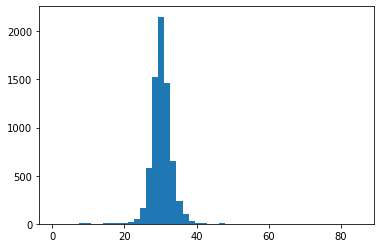


RIGHT_EYE_CENTER_Y

count    7049.000000
mean       37.975901
std         3.032590
min         4.091264
25%        36.327178
50%        37.812736
75%        39.565928
max        81.270911
Name: right_eye_center_y, dtype: float64

PLOT:


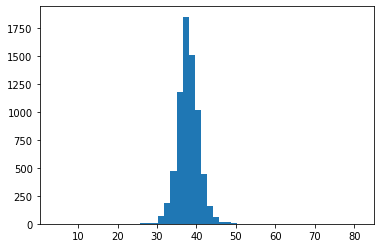


LEFT_EYE_INNER_CORNER_X

count    7049.000000
mean       59.224060
std         1.537961
min        19.064954
25%        59.255347
50%        59.255347
75%        59.255347
max        84.440991
Name: left_eye_inner_corner_x, dtype: float64

PLOT:


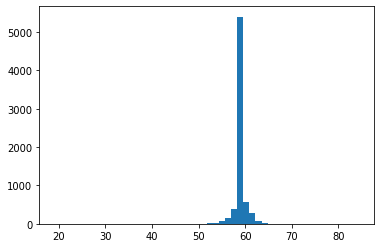


LEFT_EYE_INNER_CORNER_Y

count    7049.000000
mean       36.675731
std         1.581946
min        27.190098
25%        36.065143
50%        36.065143
75%        36.499692
max        66.562559
Name: left_eye_inner_corner_y, dtype: float64

PLOT:


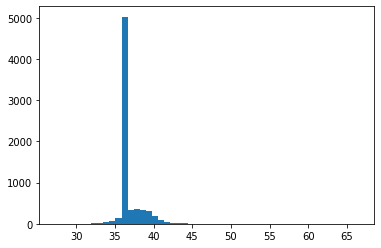


LEFT_EYE_OUTER_CORNER_X

count    7049.000000
mean       73.746775
std         1.961901
min        27.571879
25%        73.942694
50%        73.942694
75%        73.942694
max        95.258090
Name: left_eye_outer_corner_x, dtype: float64

PLOT:


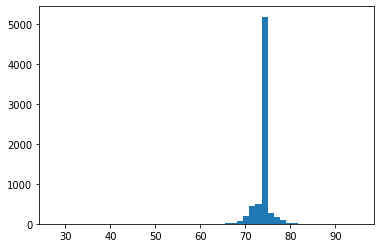


LEFT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       35.619961
std         2.184829
min        26.250023
25%        34.624653
50%        34.624653
75%        35.902613
max        64.618230
Name: left_eye_outer_corner_y, dtype: float64

PLOT:


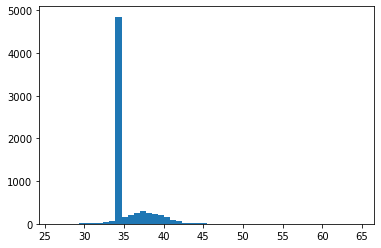


RIGHT_EYE_INNER_CORNER_X

count    7049.000000
mean       37.214171
std         1.393110
min         5.751046
25%        37.478531
50%        37.478531
75%        37.478531
max        70.714966
Name: right_eye_inner_corner_x, dtype: float64

PLOT:


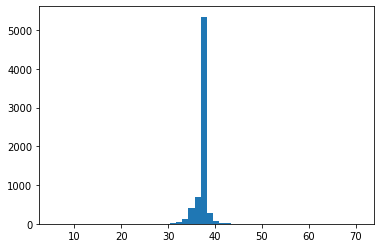


RIGHT_EYE_INNER_CORNER_Y

count    7049.000000
mean       38.942849
std         1.470456
min        26.250023
25%        39.355685
50%        39.398041
75%        39.398041
max        69.808803
Name: right_eye_inner_corner_y, dtype: float64

PLOT:


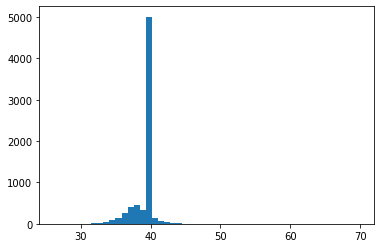


RIGHT_EYE_OUTER_CORNER_X

count    7049.000000
mean       22.162446
std         1.747700
min         3.980117
25%        22.056816
50%        22.056816
75%        22.056816
max        61.428580
Name: right_eye_outer_corner_x, dtype: float64

PLOT:


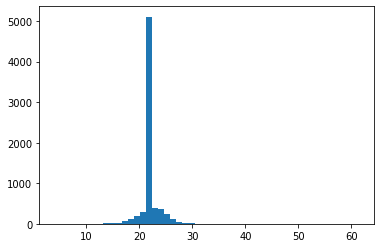


RIGHT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       39.588348
std         1.972413
min        25.123828
25%        39.645538
50%        40.330122
75%        40.330122
max        70.746797
Name: right_eye_outer_corner_y, dtype: float64

PLOT:


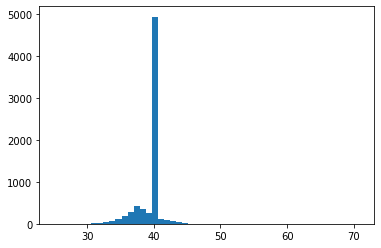


LEFT_EYEBROW_INNER_END_X

count    7049.000000
mean       54.194620
std         2.370622
min        17.888717
25%        53.299787
50%        53.299787
75%        54.311385
max        79.787831
Name: left_eyebrow_inner_end_x, dtype: float64

PLOT:


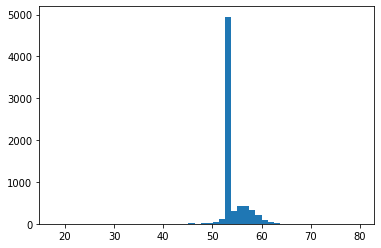


LEFT_EYEBROW_INNER_END_Y

count    7049.000000
mean       29.774418
std         1.777130
min        15.859361
25%        29.987657
50%        29.987657
75%        29.987657
max        60.875896
Name: left_eyebrow_inner_end_y, dtype: float64

PLOT:


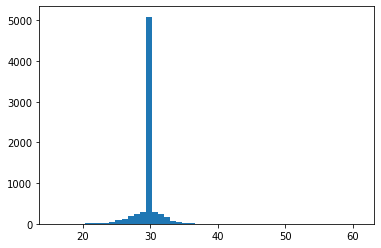


LEFT_EYEBROW_OUTER_END_X

count    7049.000000
mean       80.468907
std         2.398672
min        32.206432
25%        80.947787
50%        80.947787
75%        80.947787
max        94.269957
Name: left_eyebrow_outer_end_x, dtype: float64

PLOT:


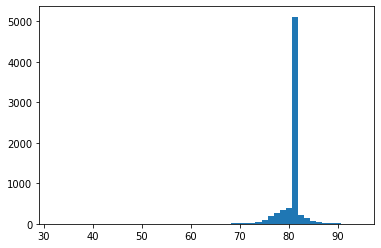


LEFT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       28.534791
std         2.314226
min        10.522325
25%        27.977535
50%        27.977535
75%        27.977535
max        60.500298
Name: left_eyebrow_outer_end_y, dtype: float64

PLOT:


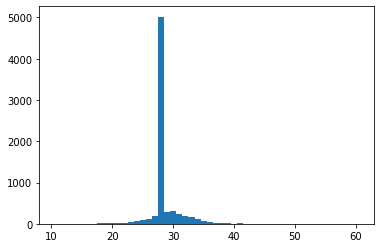


RIGHT_EYEBROW_INNER_END_X

count    7049.000000
mean       38.954169
std         1.846922
min         6.921014
25%        38.779298
50%        38.779298
75%        38.779298
max        76.582388
Name: right_eyebrow_inner_end_x, dtype: float64

PLOT:


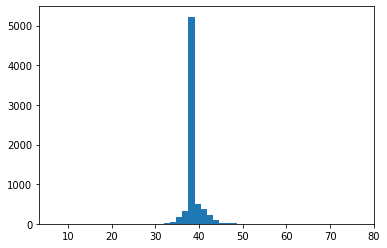


RIGHT_EYEBROW_INNER_END_Y

count    7049.000000
mean       32.070739
std         2.507250
min        16.476000
25%        31.430071
50%        33.302596
75%        33.302596
max        62.083177
Name: right_eyebrow_inner_end_y, dtype: float64

PLOT:


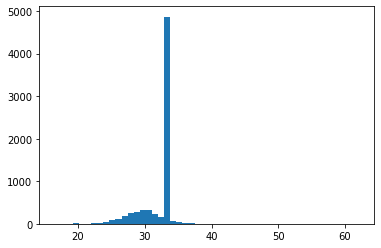


RIGHT_EYEBROW_OUTER_END_X

count    7049.000000
mean       15.138279
std         2.140417
min         3.826243
25%        14.798890
50%        14.798890
75%        14.798890
max        58.418216
Name: right_eyebrow_outer_end_x, dtype: float64

PLOT:


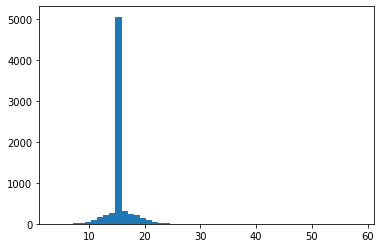


RIGHT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       34.188305
std         3.407792
min        13.224453
25%        32.994798
50%        35.982760
75%        35.982760
max        66.751329
Name: right_eyebrow_outer_end_y, dtype: float64

PLOT:


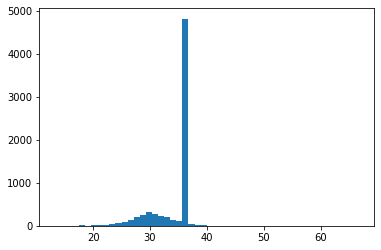


NOSE_TIP_X

count    7049.000000
mean       48.374186
std         4.280038
min        12.944699
25%        46.602370
50%        48.424713
75%        50.330437
max        89.438592
Name: nose_tip_x, dtype: float64

PLOT:


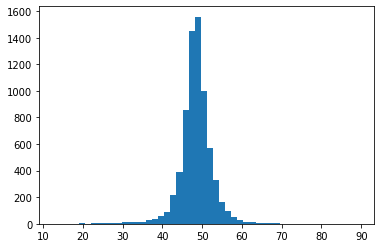


NOSE_TIP_Y

count    7049.000000
mean       62.715884
std         5.720567
min        17.932414
25%        59.292697
50%        63.451421
75%        66.492686
max        95.935644
Name: nose_tip_y, dtype: float64

PLOT:


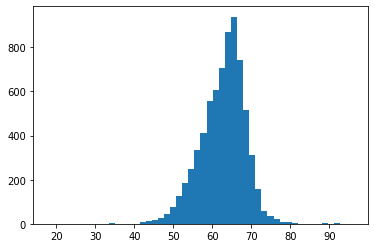


MOUTH_LEFT_CORNER_X

count    7049.000000
mean       69.586932
std         4.932241
min        22.923362
25%        65.731401
50%        72.600433
75%        72.600433
max        84.767123
Name: mouth_left_corner_x, dtype: float64

PLOT:


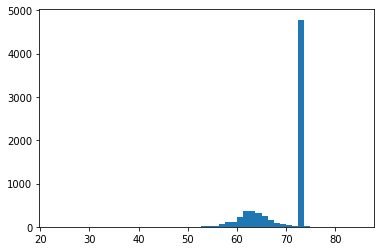


MOUTH_LEFT_CORNER_Y

count    7049.000000
mean       73.195985
std         3.242852
min        57.023258
25%        71.862041
50%        71.862041
75%        72.591200
max        94.673637
Name: mouth_left_corner_y, dtype: float64

PLOT:


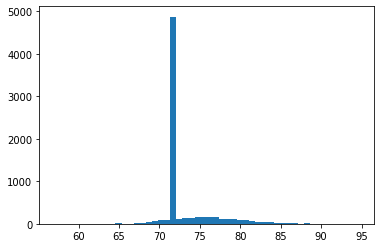


MOUTH_RIGHT_CORNER_X

count    7049.000000
mean       33.799680
std         2.350229
min         2.245766
25%        34.232759
50%        34.232759
75%        34.232759
max        74.017993
Name: mouth_right_corner_x, dtype: float64

PLOT:


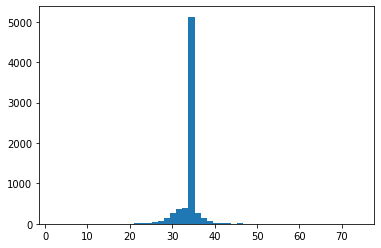


MOUTH_RIGHT_CORNER_Y

count    7049.000000
mean       76.964546
std         2.578721
min        56.690208
25%        77.339429
50%        77.339429
75%        77.339429
max        95.510678
Name: mouth_right_corner_y, dtype: float64

PLOT:


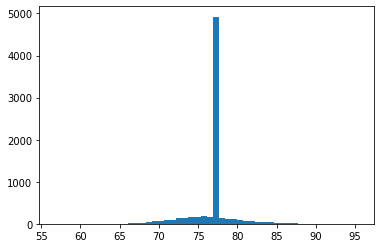


MOUTH_CENTER_TOP_LIP_X

count    7049.000000
mean       50.425299
std         2.543271
min        12.605173
25%        49.471414
50%        51.599453
75%        51.599453
max        83.989082
Name: mouth_center_top_lip_x, dtype: float64

PLOT:


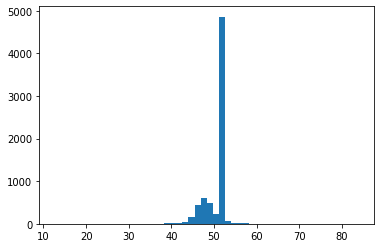


MOUTH_CENTER_TOP_LIP_Y

count    7049.000000
mean       74.982529
std         3.294983
min        56.719043
25%        75.963592
50%        75.963592
75%        75.963592
max        94.548359
Name: mouth_center_top_lip_y, dtype: float64

PLOT:


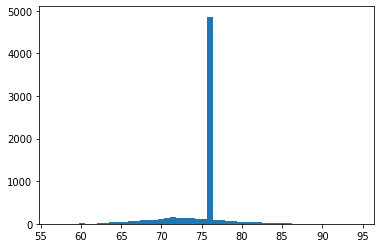


MOUTH_CENTER_BOTTOM_LIP_X

count    7049.000000
mean       48.565976
std         4.266848
min        12.536477
25%        46.571821
50%        48.588662
75%        50.676559
max        89.438592
Name: mouth_center_bottom_lip_x, dtype: float64

PLOT:


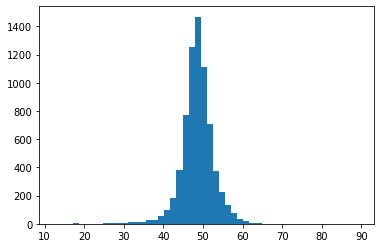


MOUTH_CENTER_BOTTOM_LIP_Y

count    7049.000000
mean       78.979256
std         5.406621
min        25.850503
25%        75.553726
50%        78.704640
75%        82.236528
max        95.808983
Name: mouth_center_bottom_lip_y, dtype: float64

PLOT:


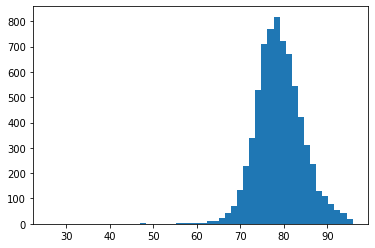

In [106]:
# after ffill imputation (run forward fill cell in Impute Missing Values section below)
for col in train.drop(columns = "Image"):
    print(col.upper())
    print()
    print(train_ffill[col].describe())
    print()
    print("PLOT:")
    plt.hist(col, data = train_ffill, bins = 50)
    plt.show()
    print()

LEFT_EYE_CENTER_X

count    7049.000000
mean       66.356767
std         3.459907
min        22.763345
25%        65.082643
50%        66.493907
75%        68.024628
max        94.689280
Name: left_eye_center_x, dtype: float64

PLOT:


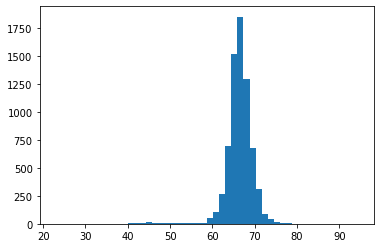


LEFT_EYE_CENTER_Y

count    7049.000000
mean       37.652355
std         3.151940
min         1.616512
25%        35.903738
50%        37.530713
75%        39.262316
max        80.502649
Name: left_eye_center_y, dtype: float64

PLOT:


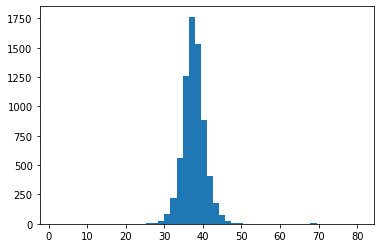


RIGHT_EYE_CENTER_X

count    7049.000000
mean       30.303921
std         3.087634
min         0.686592
25%        28.784052
50%        30.254834
75%        31.768309
max        85.039381
Name: right_eye_center_x, dtype: float64

PLOT:


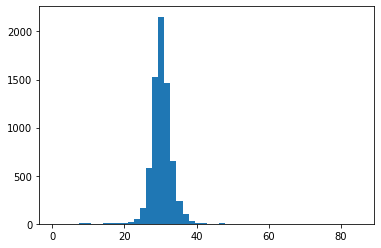


RIGHT_EYE_CENTER_Y

count    7049.000000
mean       37.975686
std         3.033783
min         4.091264
25%        36.327178
50%        37.812343
75%        39.562962
max        81.270911
Name: right_eye_center_y, dtype: float64

PLOT:


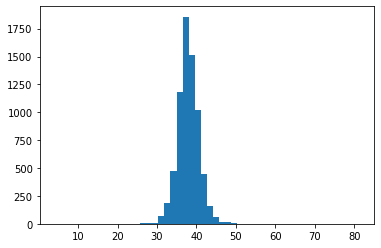


LEFT_EYE_INNER_CORNER_X

count    7049.000000
mean       59.138509
std         2.453359
min        19.064954
25%        58.556154
50%        59.426104
75%        60.183901
max        84.440991
Name: left_eye_inner_corner_x, dtype: float64

PLOT:


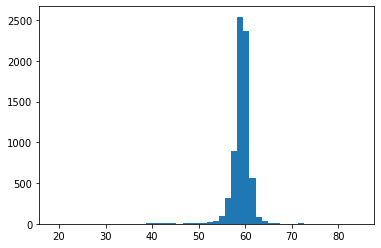


LEFT_EYE_INNER_CORNER_Y

count    7049.000000
mean       38.390901
std         1.849761
min        27.190098
25%        37.391628
50%        38.427818
75%        39.377337
max        66.562559
Name: left_eye_inner_corner_y, dtype: float64

PLOT:


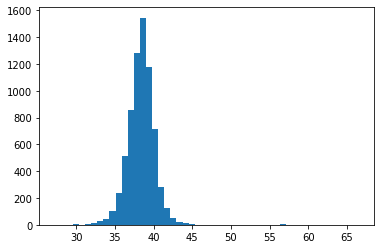


LEFT_EYE_OUTER_CORNER_X

count    7049.000000
mean       73.403158
std         3.059299
min        27.571879
25%        72.259385
50%        73.588379
75%        74.840792
max        95.258090
Name: left_eye_outer_corner_x, dtype: float64

PLOT:


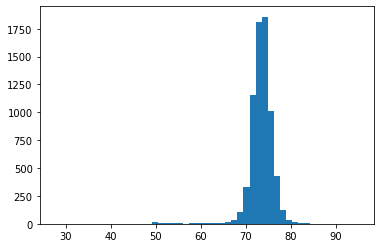


LEFT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       37.885279
std         2.549173
min        26.250023
25%        36.368647
50%        37.934202
75%        39.381025
max        64.618230
Name: left_eye_outer_corner_y, dtype: float64

PLOT:


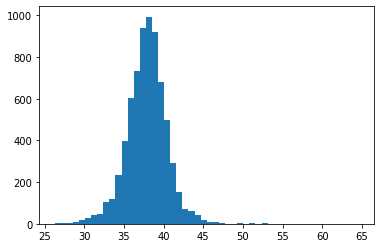


RIGHT_EYE_INNER_CORNER_X

count    7049.000000
mean       36.923997
std         1.961658
min         5.751046
25%        36.213474
50%        37.029517
75%        37.765604
max        70.714966
Name: right_eye_inner_corner_x, dtype: float64

PLOT:


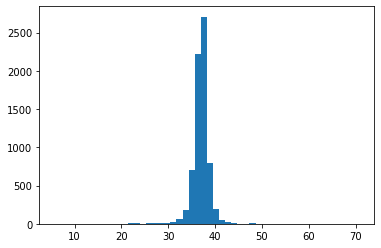


RIGHT_EYE_INNER_CORNER_Y

count    7049.000000
mean       38.487088
std         1.795371
min        26.250023
25%        37.593301
50%        38.494018
75%        39.452409
max        69.808803
Name: right_eye_inner_corner_y, dtype: float64

PLOT:


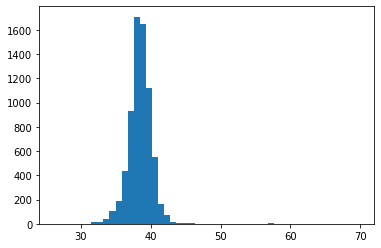


RIGHT_EYE_OUTER_CORNER_X

count    7049.000000
mean       22.608128
std         2.504552
min         3.980117
25%        21.215724
50%        22.767374
75%        24.079816
max        61.428580
Name: right_eye_outer_corner_x, dtype: float64

PLOT:


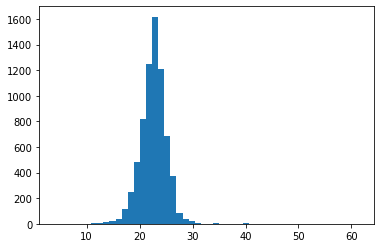


RIGHT_EYE_OUTER_CORNER_Y

count    7049.000000
mean       38.331373
std         2.389814
min        25.123828
25%        37.146172
50%        38.278853
75%        39.543104
max        70.746797
Name: right_eye_outer_corner_y, dtype: float64

PLOT:


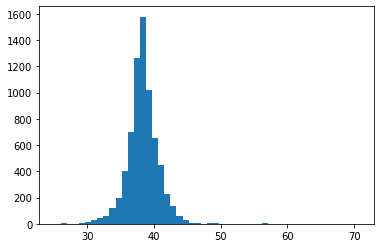


LEFT_EYEBROW_INNER_END_X

count    7049.000000
mean       56.214702
std         3.102983
min        17.888717
25%        55.193354
50%        56.574094
75%        57.772918
max        79.787831
Name: left_eyebrow_inner_end_x, dtype: float64

PLOT:


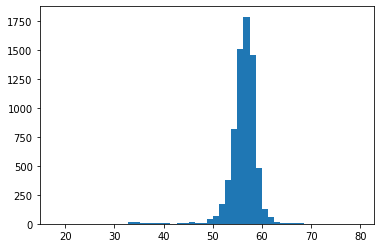


LEFT_EYEBROW_INNER_END_Y

count    7049.000000
mean       30.422734
std         2.396626
min        15.859361
25%        29.264872
50%        30.500902
75%        31.824545
max        60.875896
Name: left_eyebrow_inner_end_y, dtype: float64

PLOT:


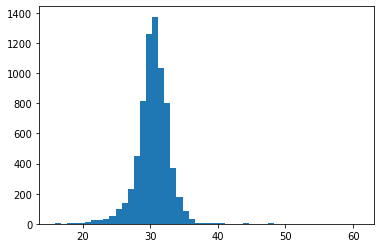


LEFT_EYEBROW_OUTER_END_X

count    7049.000000
mean       79.299739
std         3.618137
min        32.206432
25%        77.976303
50%        79.572994
75%        81.121176
max        94.269957
Name: left_eyebrow_outer_end_x, dtype: float64

PLOT:


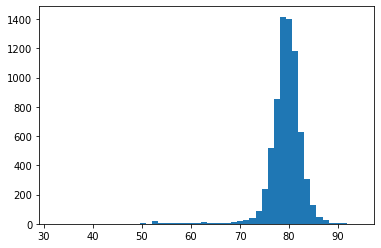


LEFT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       29.812510
std         3.083696
min        10.522325
25%        28.110751
50%        29.943631
75%        31.504639
max        60.500298
Name: left_eyebrow_outer_end_y, dtype: float64

PLOT:


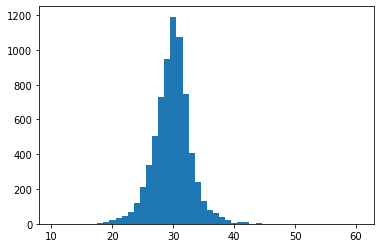


RIGHT_EYEBROW_INNER_END_X

count    7049.000000
mean       39.621208
std         2.637254
min         6.921014
25%        38.450574
50%        39.689224
75%        40.856078
max        76.582388
Name: right_eyebrow_inner_end_x, dtype: float64

PLOT:


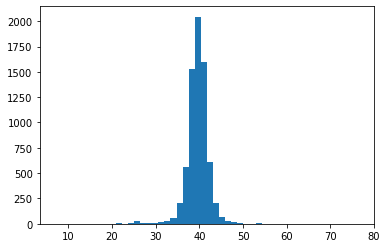


RIGHT_EYEBROW_INNER_END_Y

count    7049.000000
mean       30.719010
std         2.460344
min        16.476000
25%        29.463496
50%        30.841061
75%        32.241311
max        62.083177
Name: right_eyebrow_inner_end_y, dtype: float64

PLOT:


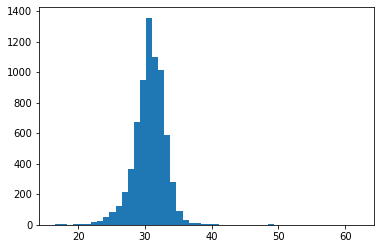


RIGHT_EYEBROW_OUTER_END_X

count    7049.000000
mean       16.109542
std         2.917398
min         3.826243
25%        14.275693
50%        16.239037
75%        17.891459
max        58.418216
Name: right_eyebrow_outer_end_x, dtype: float64

PLOT:


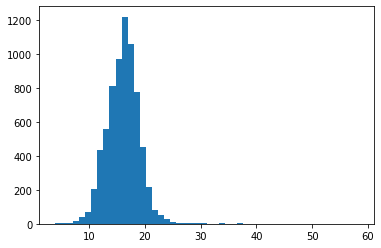


RIGHT_EYEBROW_OUTER_END_Y

count    7049.000000
mean       30.800537
std         3.150418
min        13.224453
25%        29.064521
50%        30.641520
75%        32.730569
max        66.751329
Name: right_eyebrow_outer_end_y, dtype: float64

PLOT:


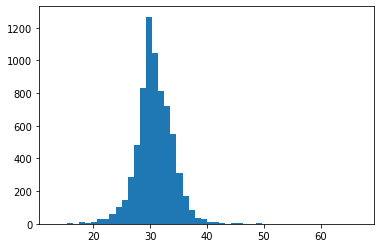


NOSE_TIP_X

count    7049.000000
mean       48.374186
std         4.280038
min        12.944699
25%        46.602370
50%        48.424713
75%        50.330437
max        89.438592
Name: nose_tip_x, dtype: float64

PLOT:


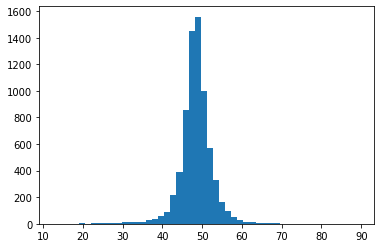


NOSE_TIP_Y

count    7049.000000
mean       62.715884
std         5.720567
min        17.932414
25%        59.292697
50%        63.451421
75%        66.492686
max        95.935644
Name: nose_tip_y, dtype: float64

PLOT:


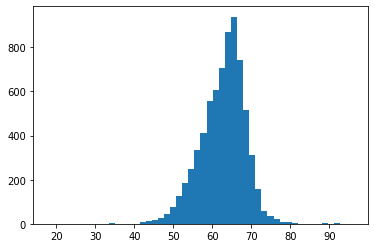


MOUTH_LEFT_CORNER_X

count    7049.000000
mean       63.552790
std         3.806871
min        22.923362
25%        61.724284
50%        63.550907
75%        65.623482
max        84.767123
Name: mouth_left_corner_x, dtype: float64

PLOT:


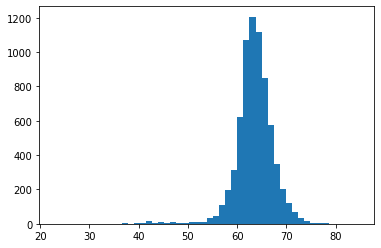


MOUTH_LEFT_CORNER_Y

count    7049.000000
mean       75.710474
std         3.881517
min        57.023258
25%        73.066463
50%        75.589817
75%        78.215444
max        94.673637
Name: mouth_left_corner_y, dtype: float64

PLOT:


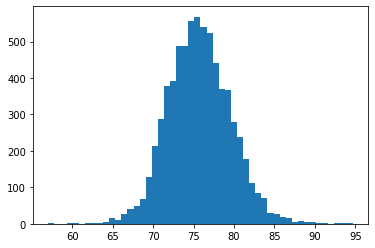


MOUTH_RIGHT_CORNER_X

count    7049.000000
mean       33.189337
std         3.310268
min         2.245766
25%        31.604651
50%        33.169928
75%        34.998278
max        74.017993
Name: mouth_right_corner_x, dtype: float64

PLOT:


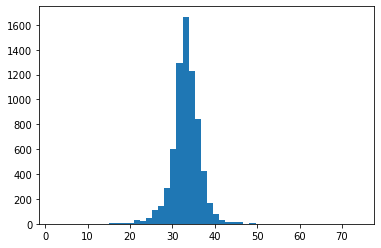


MOUTH_RIGHT_CORNER_Y

count    7049.000000
mean       75.965151
std         3.960186
min        56.690208
25%        73.238947
50%        75.839407
75%        78.626683
max        95.510678
Name: mouth_right_corner_y, dtype: float64

PLOT:


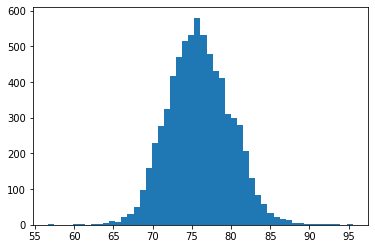


MOUTH_CENTER_TOP_LIP_X

count    7049.000000
mean       48.324771
std         3.350786
min        12.605173
25%        46.977503
50%        48.311919
75%        49.811810
max        83.989082
Name: mouth_center_top_lip_x, dtype: float64

PLOT:


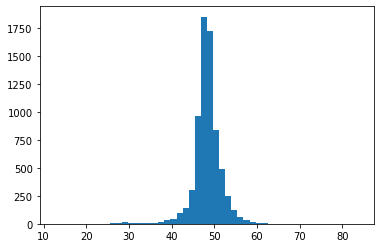


MOUTH_CENTER_TOP_LIP_Y

count    7049.000000
mean       74.257297
std         4.384867
min        56.719043
25%        71.517091
50%        74.244801
75%        77.111538
max        94.548359
Name: mouth_center_top_lip_y, dtype: float64

PLOT:


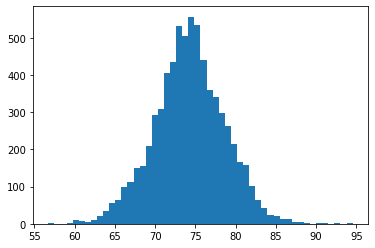


MOUTH_CENTER_BOTTOM_LIP_X

count    7049.000000
mean       48.571066
std         4.297362
min        12.536477
25%        46.572667
50%        48.595473
75%        50.679750
max        89.438592
Name: mouth_center_bottom_lip_x, dtype: float64

PLOT:


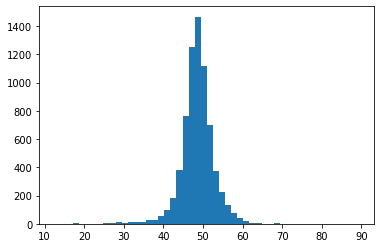


MOUTH_CENTER_BOTTOM_LIP_Y

count    7049.000000
mean       78.982463
std         5.415305
min        25.850503
25%        75.553280
50%        78.698261
75%        82.237785
max        95.808983
Name: mouth_center_bottom_lip_y, dtype: float64

PLOT:


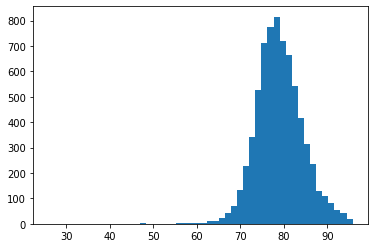

In [99]:
# after knn imputation (run KNN cell in Impute Missing Values section below)
tmp = pd.DataFrame(train_imp, columns = train.drop(columns = "Image").columns)
for col in train.drop(columns = "Image"):
    print(col.upper())
    print()
    print(tmp[col].describe())
    print()
    print("PLOT:")
    plt.hist(col, data = tmp, bins = 50)
    plt.show()
    print()

In [7]:
# plot random images
def plot_n_images(n):
    """
    plot n images from training data
    """
    img_nums = np.random.randint(0, train_data.shape[0], size = n)
    for num in img_nums:
        plt.imshow(train_data[num],cmap='gray')
        plt.show()

### Impute Missing Values

#### Forward Fill

In [8]:
# impute missing values
train_ffill = train.fillna(method = "ffill")

#### KNN

In [97]:
# scale data (optimal for KNN distances)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.drop(columns = "Image"))
train_labels_scaled = scaler.fit_transform(train_labels)
mini_train_labels_scaled = scaler.fit_transform(mini_train_labels)
dev_labels_scaled = scaler.fit_transform(dev_labels)

# KNN Imputation (K = 5)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train_knn = imputer.fit_transform(train.drop(columns="Image"))
train_labels_knn = imputer.fit_transform(train_labels)
mini_train_labels_knn = imputer.fit_transform(mini_train_labels)
dev_labels_knn = imputer.fit_transform(dev_labels)

# Inverse transform after imputation for viewing performance on images
# train_scaled_inverse = scaler.inverse_transform(train_knn)
# train_labels_scaled_inverse = scaler.inverse_transform(train_labels_knn)
# mini_train_labels_scaled_inverse = scaler.inverse_transform(mini_train_labels_knn)
# dev_labels_scaled_inverse = scaler.inverse_transform(dev_labels_knn)

In [10]:
# confirm no more missing values
pd.DataFrame(data = train_knn, columns = train.drop(columns="Image").columns.tolist()).isna().sum() / len(train) * 100

left_eye_center_x            0.0
left_eye_center_y            0.0
right_eye_center_x           0.0
right_eye_center_y           0.0
left_eye_inner_corner_x      0.0
left_eye_inner_corner_y      0.0
left_eye_outer_corner_x      0.0
left_eye_outer_corner_y      0.0
right_eye_inner_corner_x     0.0
right_eye_inner_corner_y     0.0
right_eye_outer_corner_x     0.0
right_eye_outer_corner_y     0.0
left_eyebrow_inner_end_x     0.0
left_eyebrow_inner_end_y     0.0
left_eyebrow_outer_end_x     0.0
left_eyebrow_outer_end_y     0.0
right_eyebrow_inner_end_x    0.0
right_eyebrow_inner_end_y    0.0
right_eyebrow_outer_end_x    0.0
right_eyebrow_outer_end_y    0.0
nose_tip_x                   0.0
nose_tip_y                   0.0
mouth_left_corner_x          0.0
mouth_left_corner_y          0.0
mouth_right_corner_x         0.0
mouth_right_corner_y         0.0
mouth_center_top_lip_x       0.0
mouth_center_top_lip_y       0.0
mouth_center_bottom_lip_x    0.0
mouth_center_bottom_lip_y    0.0
dtype: flo

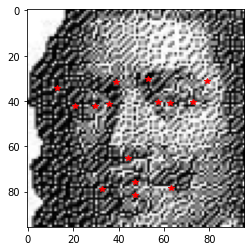

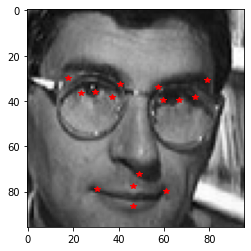

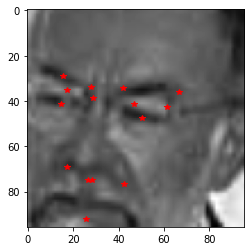

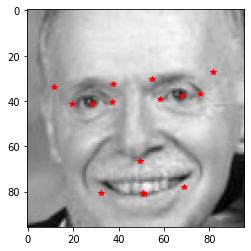

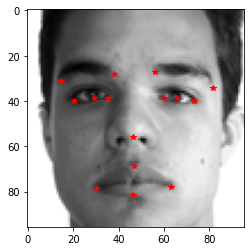

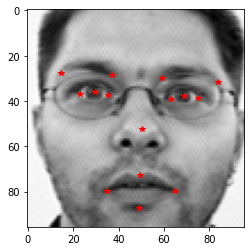

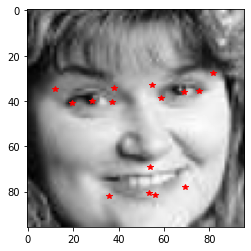

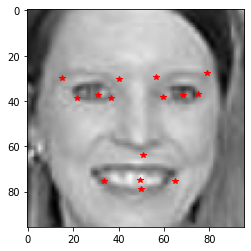

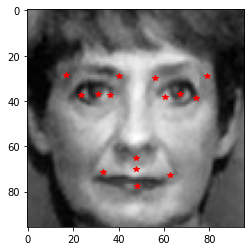

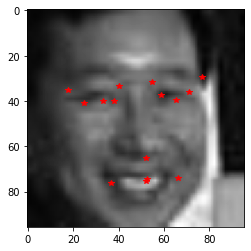

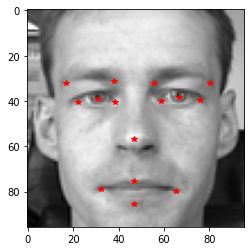

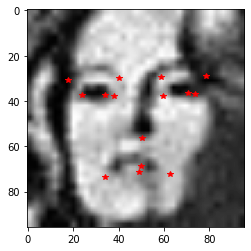

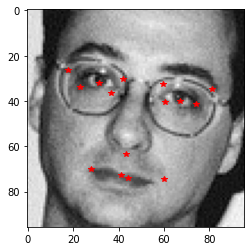

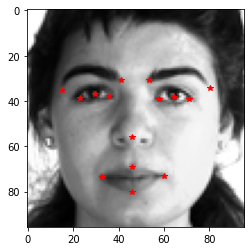

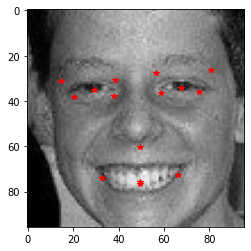

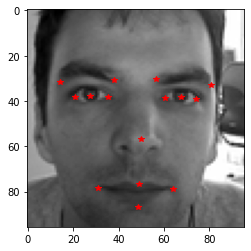

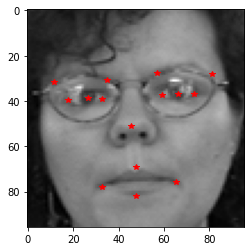

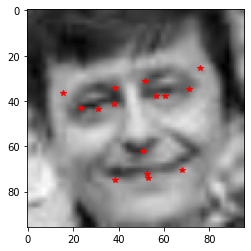

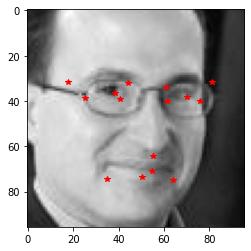

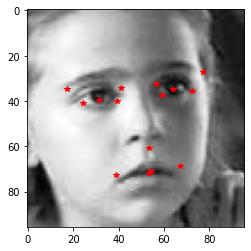

In [109]:
#explore some of the images in the training data (KNN imputation)
for i in train[train['left_eye_outer_corner_y'].notna()].index[:20]:
    plt.imshow(X[i],cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(train_labels_knn[i][loc], train_labels_knn[i][loc+1], '*r')
    plt.show()

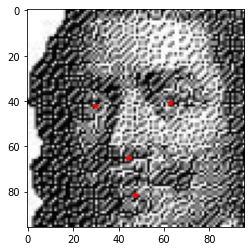

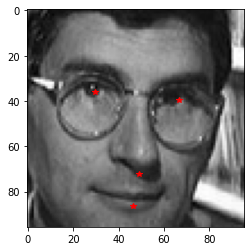

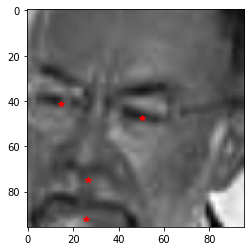

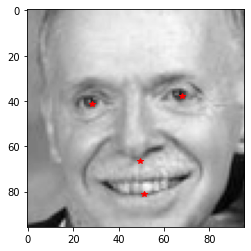

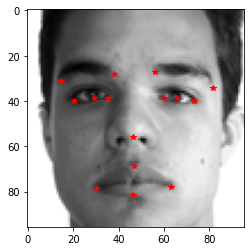

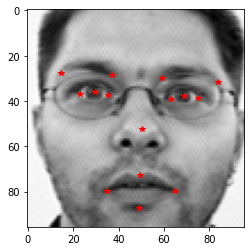

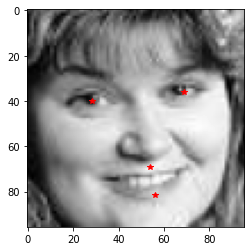

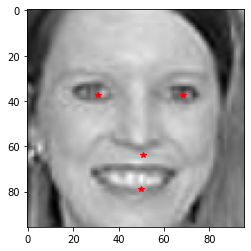

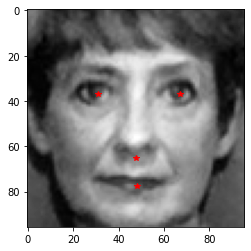

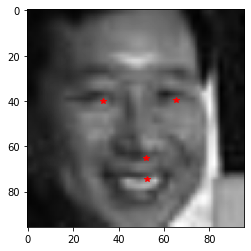

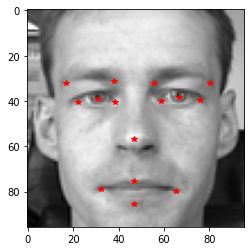

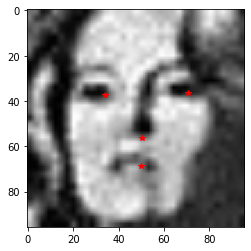

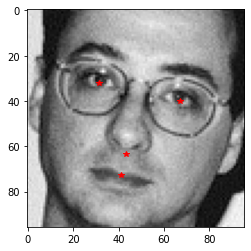

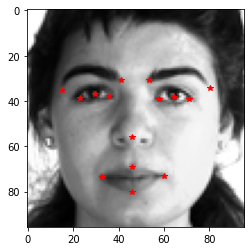

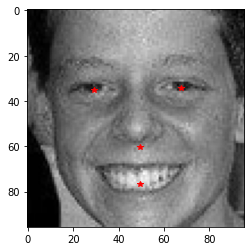

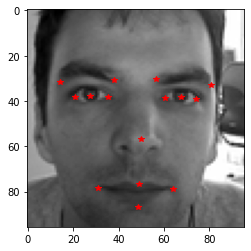

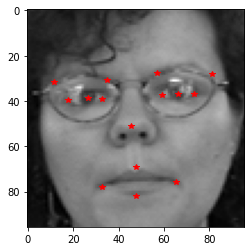

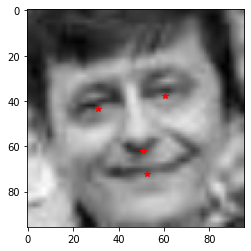

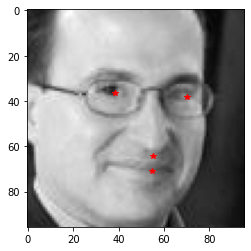

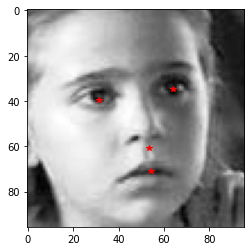

In [108]:
#explore some of the images in the training data (no imputation)
for i in train[train['left_eye_outer_corner_y'].notna()].index[:20]:
    plt.imshow(X[i],cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(Y[i][loc], Y[i][loc+1], '*r')
    plt.show()

In [102]:
# transform Y for ffill in same way as non-ffill data (create for ffill imputation visuals)
Y_ffill = np.array([train_ffill.drop('Image', axis = 1).iloc[i] for i in range(len(train_ffill))])
Y_ffill = Y_ffill[shuffle]

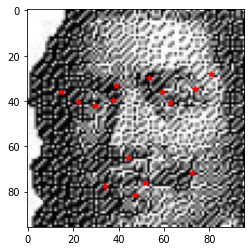

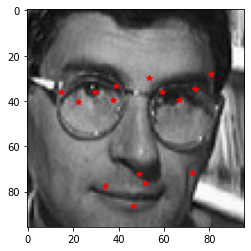

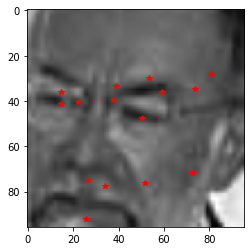

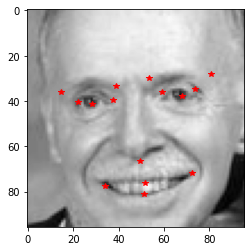

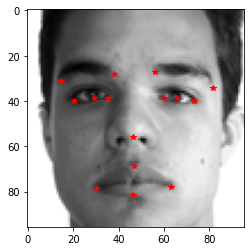

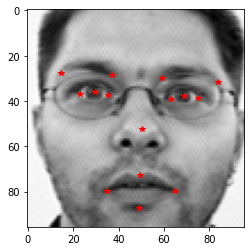

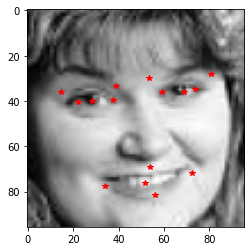

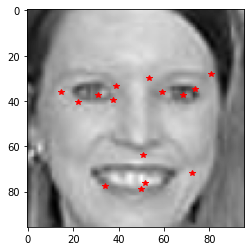

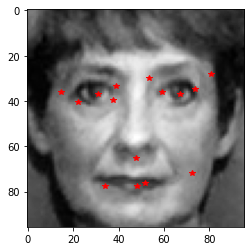

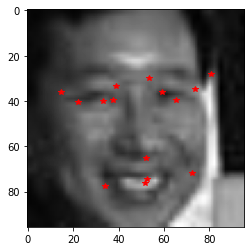

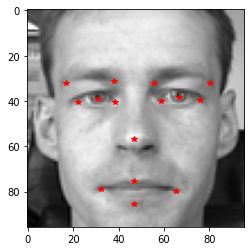

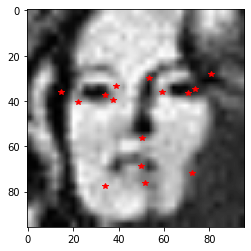

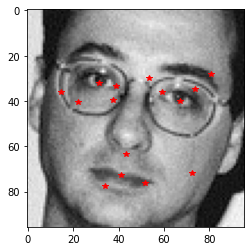

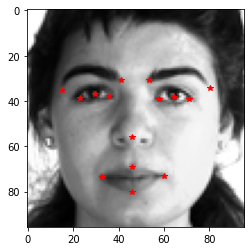

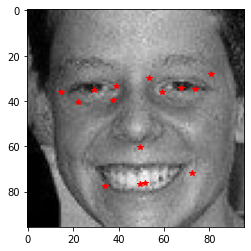

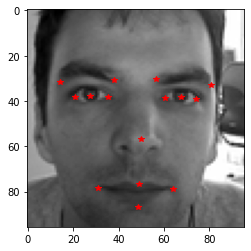

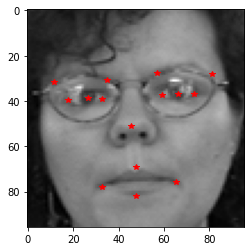

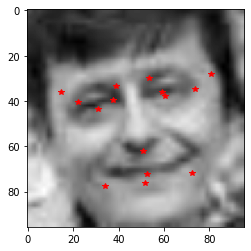

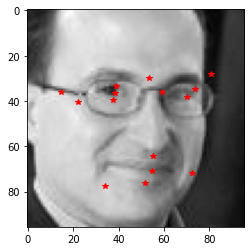

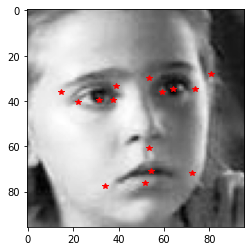

In [103]:
#explore some of the images in the training data (ffill imputation)
for i in train[train['left_eye_outer_corner_y'].notna()].index[:20]:
    plt.imshow(train_data[i],cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(Y_ffill[i][loc], Y_ffill[i][loc+1], '*r')
    plt.show()

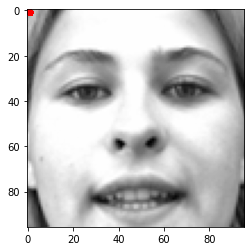

In [85]:
#explore some of the images in the training data (ffill)
# for i in train[train['left_eye_outer_corner_y'].isna()].index[:20]:
num = 1100
plt.imshow(noNA_train_data[num].reshape(96,96),cmap='gray')
#place a point for each of the pictures on the specified coordinates
for loc in range(0, len(noNA_train_labels[num]),2):
    plt.plot(noNA_train_data[num].reshape(96,96)[loc], noNA_train_data[num].reshape(96,96)[loc+1], '*r')
plt.show()

In [ ]:
#explore some of the images in the training data (KNN)
for i in range(20):
    plt.imshow(noNA_train_data[i].reshape(96,96),cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(train_labels[i]),2):
        plt.plot(noNA_train_labels[i][loc], noNA_train_labels[i][loc+1], '*r')
    plt.show()

## Modeling on the data
First we will look at the full dataset with NAs

In [55]:
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(train_data, train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(dev_data, dev_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 43.80
Test score: nan
Test accuracy: 0.007808687165379524


With so many NAs in the data, the model is not able to perform. Now we will do the same model but on the cleaned noNA datasets

In [56]:
model = Sequential()
# model.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(noNA_train_data, noNA_train_labels, shuffle=False, batch_size=1, verbose=0, epochs=10) 
print ('Train time = %.2f' %(time.time() - start_time))
score = model.evaluate(noNA_dev_data, noNA_dev_labels, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train time = 11.39
Test score: 10244261888.0
Test accuracy: 0.5255318880081177


In [57]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 30)                276510    
                                                                 
Total params: 276,510
Trainable params: 276,510
Non-trainable params: 0
_________________________________________________________________


## Let's try adding more layers

In [58]:
model2 = Sequential()
model2.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model2.add(Dense(30, input_dim=30, activation='softmax'))
model2.add(Dropout(0.5))
model2.add(Dense(units=30, input_dim=30, activation='softmax'))

sgd = optimizers.SGD(lr=0.0001)
model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model2.fit(noNA_train_data, noNA_train_labels, shuffle=False, batch_size=10, verbose=0, epochs=50) 
print ('Train time = %.2f' %(time.time() - start_time))
score2 = model2.evaluate(noNA_dev_data, noNA_dev_labels, verbose=0) 
print('Test score:', score2[0]) 
print('Test accuracy:', score2[1])

Train time = 11.73
Test score: 600638.0625
Test accuracy: 0.5255318880081177


No additional gain on original model. Need to review why this is the case. Any ideas?

In [59]:
model2.summary() 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 30)                276510    
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_11 (Dense)            (None, 30)                930       
                                                                 
Total params: 277,440
Trainable params: 277,440
Non-trainable params: 0
_________________________________________________________________


## Convolutional Model Baseline Attempt

In [61]:
#reshape data into 2D arrays
x_train_96x96 = noNA_train_data.reshape(noNA_train_data.shape[0], 96, 96, 1)
x_dev_96x96 = noNA_dev_data.reshape(noNA_dev_data.shape[0], 96, 96, 1)

model = Sequential() 
model.add(Conv2D(96, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model.add(Conv2D(192, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=50, input_dim=384, activation='sigmoid')) 
model.add(Dense(units=30, input_dim=50, activation='softmax')) 

## Cost function & Objective (and solver)
sgd = optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_96x96, noNA_train_labels, batch_size=100, epochs=5, verbose=1, validation_data=(x_dev_96x96, noNA_dev_labels))
score = model.evaluate(x_dev_96x96, noNA_dev_labels, verbose=0)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/5
12/12 [==============================] - 38s 3s/step - loss: 57390.1328 - accuracy: 0.6942 - val_loss: 129342.9453 - val_accuracy: 0.5255
Epoch 2/5
12/12 [==============================] - 39s 3s/step - loss: 190228.4219 - accuracy: 0.8458 - val_loss: 263987.4062 - val_accuracy: 0.5255
Epoch 3/5
12/12 [==============================] - 37s 3s/step - loss: 324449.7812 - accuracy: 0.8458 - val_loss: 398631.8438 - val_accuracy: 0.5255
Epoch 4/5
12/12 [==============================] - 38s 3s/step - loss: 458200.6875 - accuracy: 0.8458 - val_loss: 533275.9375 - val_accuracy: 0.5255
Epoch 5/5
12/12 [==============================] - 37s 3s/step - loss: 592549.4375 - accuracy: 0.8458 - val_loss: 667920.3125 - val_accuracy: 0.5255
Test score: 667920.25
Test accuracy: 0.5255318880081177


Again, no improvement in the test accuracy even with additional layers. No changes with batch size, epochs, or learning rate.

In [63]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 96)        960       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 192)       166080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 192)      0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 46, 46, 192)       0         
                                                                 
 flatten (Flatten)           (None, 406272)            0         
                                                                 
 dense_12 (Dense)            (None, 50)                20313650  
                                                     

## Appendix: More EDA

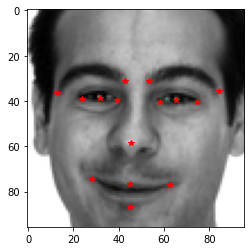

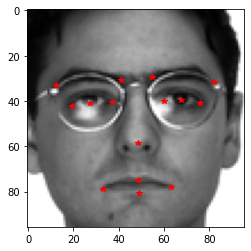

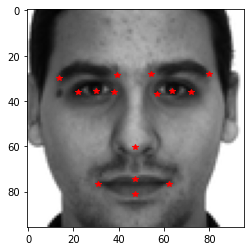

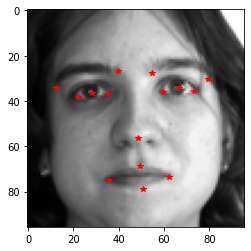

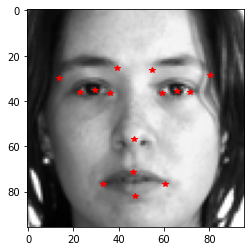

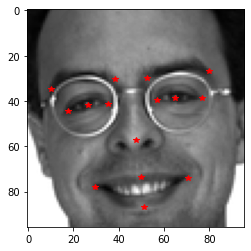

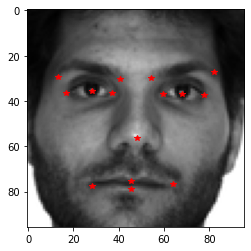

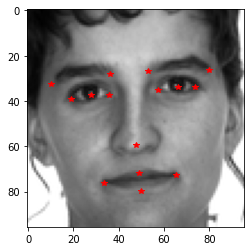

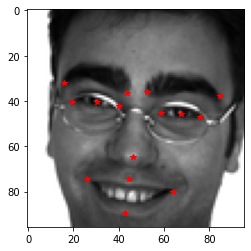

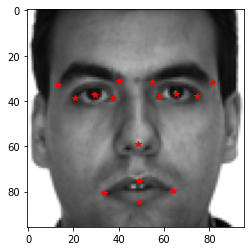

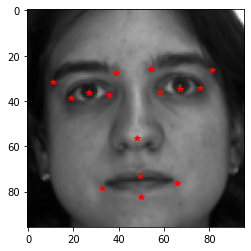

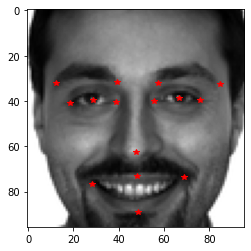

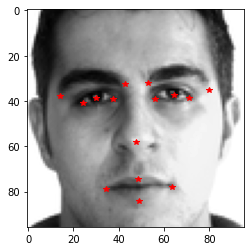

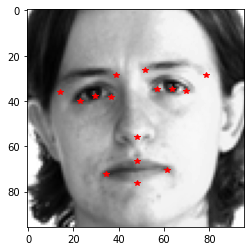

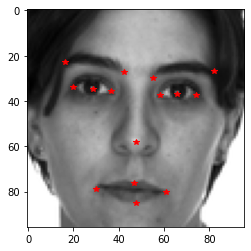

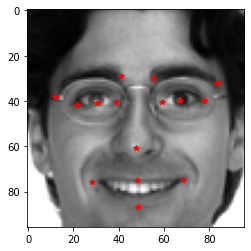

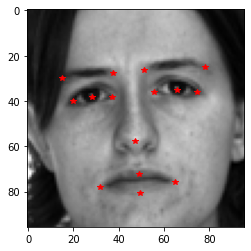

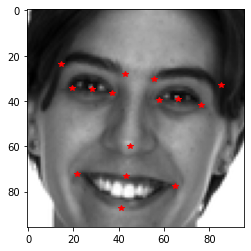

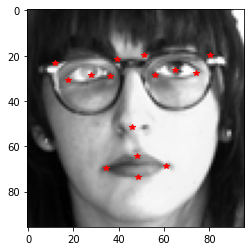

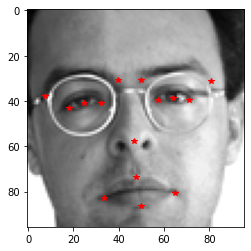

In [64]:
for i in range(20):
    plt.imshow(noNA_dev_data[i].reshape(96,96),cmap='gray')
    #place a point for each of the pictures on the specified coordinates
    for loc in range(0, len(noNA_dev_labels[i]),2):
        plt.plot(noNA_dev_labels[i][loc], noNA_dev_labels[i][loc+1], '*r')
    plt.show()
    